In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import interp1d

from SiPM import SiPMClass
from WaveformGenerator import WaveformClass
from NSB import NSBClass
from Shower import ShowerClass
import ROOT as root
import pickle
import math

In [8]:
def generalized_poisson(k, mu, mu_xt, amplitude=1):
    """
    Reference can be found here: https://arxiv.org/pdf/math/0606238.pdf
    S. Vinogradov https://arxiv.org/pdf/1109.2014.pdf
    :param k:
    :param mu:
    :param mu_xt:
    :param amplitude:
    :return:
    """

    if mu_xt < 0 or mu < 0:

        if isinstance(k, int):
            return 0
        else:
            return np.zeros(len(k))

    else:

        log_amplitude = np.log(amplitude)
        log_mu = np.log(mu)

        temp = np.ones((len(k), k.max()))

        temp[:] = np.arange(1, k.max() + 1)
        mask = np.triu_indices(n=temp.shape[0], m=temp.shape[1])
        temp[mask] = 1

        temp = np.log(temp)
        log_k = np.sum(temp, axis=-1)

        pdf = log_amplitude + log_mu
        pdf = pdf + np.log(mu + k * mu_xt) * (k - 1)
        pdf = pdf + (-mu - k * mu_xt) - log_k
        pdf = np.exp(pdf)

        pdf[k < 0] = 0

        return pdf

In [9]:
def generalized_poisson(k, mu, mu_xt, amplitude=1):
    """
    Reference can be found here: https://arxiv.org/pdf/math/0606238.pdf
    S. Vinogradov https://arxiv.org/pdf/1109.2014.pdf
    :param k:
    :param mu:
    :param mu_xt:
    :param amplitude:
    :return:
    """

    
    log_amplitude = np.log(amplitude)
    log_mu = np.log(mu)

    temp = np.ones((len(k), k.max()))

    temp[:] = np.arange(1, k.max() + 1)
    mask = np.triu_indices(n=temp.shape[0], m=temp.shape[1])
    temp[mask] = 1

    temp = np.log(temp)
    log_k = np.sum(temp, axis=-1)


    pdf = log_amplitude + log_mu
    
    k = k[:, np.newaxis]
    pdf = pdf + np.log(mu + k * mu_xt) * (k - 1)
    log_k = log_k[:, np.newaxis]
    
    pdf = pdf + (-np.array(mu) - k * mu_xt) - log_k
    pdf = np.exp(pdf)

    pdf[k[:,0] < 0] = 0

    return pdf

In [10]:
def gaussian(x, mean, sigma, amplitude):
    print('shape : ', x.shape)
    x = np.atleast_1d(x)
    print('shape : ', x.shape)
    pdf = (x[:, np.newaxis] - mean) ** 2 / (2 * sigma ** 2)
    print('shape : ', pdf.shape)
    pdf = np.exp(-pdf)
    pdf /= (np.sqrt(2 * np.pi) * sigma)
    pdf *= amplitude

    return pdf

In [11]:
def mpe_distribution_general_simple(mu, mu_xt, n_peaks=30):
    if n_peaks > 0:

        photoelectron_peak = np.arange(n_peaks, dtype=np.int)
        pdf = generalized_poisson(photoelectron_peak, mu, mu_xt)
        return pdf

    else:
        return 0

In [12]:
def mpe_distribution_general(x, bin_width, baseline, gain, sigma_e, sigma_s,
                             mu, mu_xt, amplitude, n_peaks=30):
    if n_peaks > 0:
        
        pdf_out = []

        x = x - baseline
        photoelectron_peak = np.arange(n_peaks, dtype=np.int)
        sigma_n = sigma_e ** 2 + photoelectron_peak * sigma_s ** 2
        # correct to bin width?)
        #sigma_n = sigma_n + bin_width ** 2 / 12
        print('x len : ', len(x))
        
        sigma_n = np.sqrt(sigma_n)

        pdf = generalized_poisson(photoelectron_peak, mu, mu_xt)
        print('pdf len : ', len(pdf))
        
        gaus_results = gaussian(x, photoelectron_peak * gain, sigma_n, 
                             amplitude=1)
        
        if len(pdf.shape) > 1:
            
            for index in range(pdf.shape[1]):
                pdf_out.append(pdf[:,index]*gaus_results)
        else:
            pdf_out.append(pdf*gaus_results)
            
        pdf_out = np.array(pdf_out)
        
        return amplitude*pdf_out
        
    else:
        return 0

x len :  100000
pdf len :  10
shape :  (100000,)
shape :  (100000,)
shape :  (100000, 10)


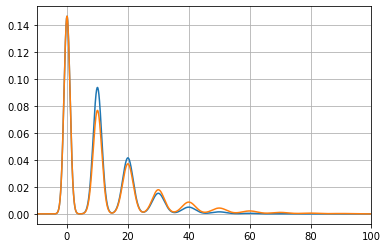

In [13]:
n = np.arange(10)
x = np.linspace(-1000, 1000, num=100000)

x_width = (x[-1] - x[0]) / len(x)
gain = 10
mu = 1
mu_xt = 0.1
sigma_e = 1
sigma_s = 1
baseline = 0
bin_width = 0
amplitude = 1

pdf = mpe_distribution_general(x, bin_width, baseline, gain, sigma_e, sigma_s, [mu, mu], [0.1, 0.3], amplitude, n_peaks=10)

plt.figure()
#plt.plot(x, pdf[0], '-')
plt.plot(x, np.sum(pdf[0], axis=-1), '-')
plt.plot(x, np.sum(pdf[1], axis=-1), '-')
#plt.legend()
plt.xlim(-10, 100)
plt.grid()
#plt.show()

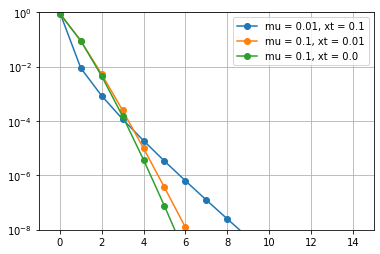

In [14]:
max_pe = 30
gain = 10
mu = [0.01, 0.1, 0.1]
mu_xt = [0.1, 0.01, 0.]
sigma_e = 1
sigma_s = 1
baseline = 0
amplitude = 1

pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=max_pe)

plt.plot(np.arange(0, max_pe, 1), pdf[:,0], 'o-', label = 'mu = 0.01, xt = 0.1')
plt.plot(np.arange(0, max_pe, 1), pdf[:,1], 'o-', label = 'mu = 0.1, xt = 0.01')
plt.plot(np.arange(0, max_pe, 1), pdf[:,2], 'o-', label = 'mu = 0.1, xt = 0.0')
#plt.plot(np.arange(0, max_pe, 1), pdf[:,3], 'o-', label = 'mu = 0., xt = 0.1')
plt.yscale('log')
plt.xlim(-1, 15)
plt.ylim(1e-8, 1)
plt.grid()
plt.legend()

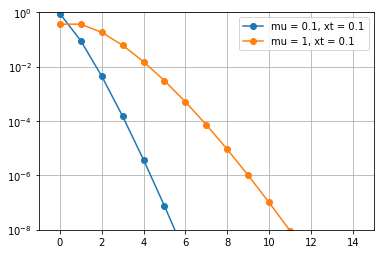

In [15]:
max_pe = 30
gain = 10
mu = [0.1, 1]
mu_xt = [0., 0.]
sigma_e = 1
sigma_s = 1
baseline = 0
amplitude = 1

pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=max_pe)

plt.plot(np.arange(0, max_pe, 1), pdf[:,0], 'o-', label = 'mu = 0.1, xt = 0.1')
plt.plot(np.arange(0, max_pe, 1), pdf[:,1], 'o-', label = 'mu = 1, xt = 0.1')
plt.yscale('log')
plt.xlim(-1, 15)
plt.ylim(1e-8, 1)
plt.grid()
plt.legend()


# waveforms

In [16]:
def load_object(file_name):
    try:
        with open(file_name, "rb") as f:
            data = pickle.load(f)
            return data
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

In [17]:
def calc_max_amplitude_long(nsb, dcr, xt, time_window = 1e-9, n_time_bisn=100, n_events = 10000, n_photoelectrons = 50):
   
    mu = (dcr + nsb)*time_window
    mu_xt = xt
    pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=n_photoelectrons)
    
    max_amplitude = calc_max_amplitude(pdf.reshape(n_photoelectrons), np.arange(0, n_photoelectrons, 1), n_time_bisn=n_time_bisn, n_events = n_events)
    
    return max_amplitude
    

In [18]:
def calc_max_amplitude(probability, values, n_time_bisn=100, n_events = 10000):
    
    data = np.random.choice(values, n_time_bisn*n_events, p=probability)
    data = data.reshape(n_time_bisn, n_events)
    return np.max(data, axis = 0)

In [19]:
def get_dark_pe(data, data_range = 800, length = 10000):
    pe = data[:,:data_range]
    return pe.reshape(data_range*length)

In [20]:
NUV_HD_25um_10p_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um_px_0.1_waveforms_data.pickle')
NUV_HD_25um_20p_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um_px_0.2_waveforms_data.pickle')
NUV_HD_25um_03p_LXT_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um-LXT_px_0.033_waveforms_data.pickle')
NUV_HD_25um_06p_LXT_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um-LXT_px_0.066_waveforms_data.pickle')
NUV_HD_25um_03p_MT_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um-MT_px_0.033_waveforms_data.pickle')
NUV_HD_25um_06p_MT_data = load_object('/run/media/andrii/Новый том/Terzina_sim/sim_results/25um/850ns/NUVHD-25um-MT_px_0.066_waveforms_data.pickle')

### Single time bin probability photon probability: 

In [21]:
NUV_HD_25um_03p_MT_pe_dark = get_dark_pe(NUV_HD_25um_03p_MT_data.amplitude_pe_detected)
NUV_HD_25um_06p_MT_pe_dark = get_dark_pe(NUV_HD_25um_06p_MT_data.amplitude_pe_detected)

NUV_HD_25um_03p_LXT_pe_data = get_dark_pe(NUV_HD_25um_03p_LXT_data.amplitude_pe_detected)
NUV_HD_25um_06p_LXT_pe_data = get_dark_pe(NUV_HD_25um_06p_LXT_data.amplitude_pe_detected)

NUV_HD_25um_10p_data_pe_data = get_dark_pe(NUV_HD_25um_10p_data.amplitude_pe_detected)
NUV_HD_25um_20p_data_pe_data = get_dark_pe(NUV_HD_25um_20p_data.amplitude_pe_detected)

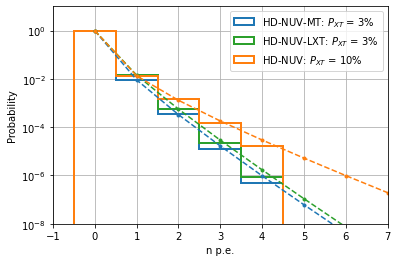

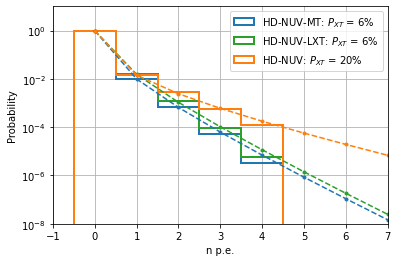

In [16]:
plt.hist(NUV_HD_25um_03p_MT_pe_dark, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'HD-NUV-MT: $P_{XT}$ = 3%')

max_pe = 50
time_bin_width = 1.e-9

NUV_HD_25um_03p_MT_mu = (NUV_HD_25um_03p_MT_data.sipm.dcr + NUV_HD_25um_03p_MT_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_03p_MT_mu_xt = NUV_HD_25um_03p_MT_data.sipm.pxt
NUV_HD_25um_03p_MT_pdf = mpe_distribution_general_simple(NUV_HD_25um_03p_MT_mu, NUV_HD_25um_03p_MT_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_MT_pdf, '.--', color = 'tab:blue')


plt.hist(NUV_HD_25um_03p_LXT_pe_data, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'HD-NUV-LXT: $P_{XT}$ = 3%')
NUV_HD_25um_03p_LXT_mu = (NUV_HD_25um_03p_LXT_data.sipm.dcr + NUV_HD_25um_03p_LXT_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_03p_LXT_mu_xt = NUV_HD_25um_03p_LXT_data.sipm.pxt
NUV_HD_25um_03p_LXT_pdf = mpe_distribution_general_simple(NUV_HD_25um_03p_LXT_mu, NUV_HD_25um_03p_LXT_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_LXT_pdf, '.--', color = 'tab:green')


plt.hist(NUV_HD_25um_10p_data_pe_data, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'HD-NUV: $P_{XT}$ = 10%')
NUV_HD_25um_10p_mu = (NUV_HD_25um_10p_data.sipm.dcr + NUV_HD_25um_10p_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_10p_mu_xt = NUV_HD_25um_10p_data.sipm.pxt
NUV_HD_25um_10p_pdf = mpe_distribution_general_simple(NUV_HD_25um_10p_mu, NUV_HD_25um_10p_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_10p_pdf, '.--', color = 'tab:orange')

plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()


plt.hist(NUV_HD_25um_06p_MT_pe_dark, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'HD-NUV-MT: $P_{XT}$ = 6%')
NUV_HD_25um_06p_MT_mu = (NUV_HD_25um_06p_MT_data.sipm.dcr + NUV_HD_25um_06p_MT_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_06p_MT_mu_xt = NUV_HD_25um_06p_MT_data.sipm.pxt
NUV_HD_25um_06p_MT_pdf = mpe_distribution_general_simple(NUV_HD_25um_06p_MT_mu, NUV_HD_25um_06p_MT_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_MT_pdf, '.--', color = 'tab:blue')

plt.hist(NUV_HD_25um_06p_LXT_pe_data, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'HD-NUV-LXT: $P_{XT}$ = 6%')
NUV_HD_25um_06p_LXT_mu = (NUV_HD_25um_06p_LXT_data.sipm.dcr + NUV_HD_25um_03p_LXT_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_06p_LXT_mu_xt = NUV_HD_25um_06p_LXT_data.sipm.pxt
NUV_HD_25um_06p_LXT_pdf = mpe_distribution_general_simple(NUV_HD_25um_06p_LXT_mu, NUV_HD_25um_06p_LXT_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_LXT_pdf, '.--', color = 'tab:green')

plt.hist(NUV_HD_25um_20p_data_pe_data, bins = 5, range = [-0.5, 4.5], 
         histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'HD-NUV: $P_{XT}$ = 20%')
NUV_HD_25um_20p_mu = (NUV_HD_25um_20p_data.sipm.dcr + NUV_HD_25um_20p_data.nsb.rate_mhz*1.e6)*time_bin_width
NUV_HD_25um_20p_mu_xt = NUV_HD_25um_20p_data.sipm.pxt
NUV_HD_25um_20p_pdf = mpe_distribution_general_simple(NUV_HD_25um_20p_mu, NUV_HD_25um_20p_mu_xt, n_peaks=max_pe)
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_20p_pdf, '.--', color = 'tab:orange')

plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

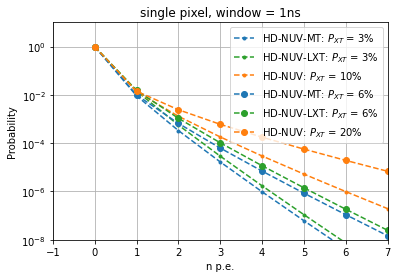

In [18]:
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_MT_pdf, '.--', color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_LXT_pdf, '.--', color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_10p_pdf, '.--', color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 10%')

plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_MT_pdf, 'o--', color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 6%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_LXT_pdf, 'o--', color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 6%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_20p_pdf, 'o--', color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 20%')
plt.grid()
plt.yscale('log')
plt.legend()
plt.title('single pixel, window = 1ns')
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

### Probability to cross the threshold: 

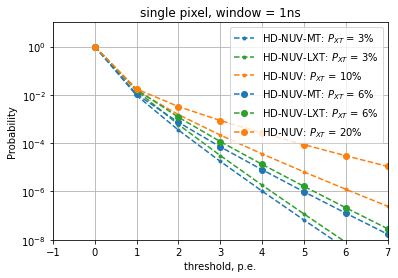

In [19]:
NUV_HD_25um_03p_MT_pdf_threshold = np.zeros(max_pe)
NUV_HD_25um_03p_LXT_pdf_threshold = np.zeros(max_pe)
NUV_HD_25um_10p_pdf_threshold = np.zeros(max_pe)

NUV_HD_25um_06p_MT_pdf_threshold = np.zeros(max_pe)
NUV_HD_25um_06p_LXT_pdf_threshold = np.zeros(max_pe)
NUV_HD_25um_20p_pdf_threshold = np.zeros(max_pe)

norm_factor = np.sum(NUV_HD_25um_03p_MT_pdf)

for ipe in range(max_pe):
    NUV_HD_25um_03p_MT_pdf_threshold[ipe] = np.sum(NUV_HD_25um_03p_MT_pdf[ipe:])/norm_factor
    NUV_HD_25um_03p_LXT_pdf_threshold[ipe] = np.sum(NUV_HD_25um_03p_LXT_pdf[ipe:])/norm_factor
    NUV_HD_25um_10p_pdf_threshold[ipe] = np.sum(NUV_HD_25um_10p_pdf[ipe:])/norm_factor
    
    NUV_HD_25um_06p_MT_pdf_threshold[ipe] = np.sum(NUV_HD_25um_06p_MT_pdf[ipe:])/norm_factor
    NUV_HD_25um_06p_LXT_pdf_threshold[ipe] = np.sum(NUV_HD_25um_06p_LXT_pdf[ipe:])/norm_factor
    NUV_HD_25um_20p_pdf_threshold[ipe] = np.sum(NUV_HD_25um_20p_pdf[ipe:])/norm_factor    
    
    
    
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_MT_pdf_threshold, '.--', 
         color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_03p_LXT_pdf_threshold, '.--', 
         color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_10p_pdf_threshold, '.--', 
         color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 10%')

plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_MT_pdf_threshold, 'o--', 
         color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 6%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_06p_LXT_pdf_threshold, 'o--', 
         color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 6%')
plt.plot(np.arange(0, max_pe, 1), NUV_HD_25um_20p_pdf_threshold, 'o--', 
         color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 20%')
    
plt.grid()
plt.yscale('log')
plt.legend()
plt.title('single pixel, window = 1ns')
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('threshold, p.e.')
plt.show()

In [20]:
NUV_HD_25um_03p_MT_pdf[1]

array([0.00906011])

In [21]:
np.sum(NUV_HD_25um_03p_MT_pdf[1:])

0.009408484879827213

### 100ns read-out window: 

In [22]:
def binomial(n, k):
    
    p1 = math.factorial(n)
    p2 = math.factorial(k)
    p3 = math.factorial(n-k)
    
    return p1/(p2*p3)

In [23]:
def get_p_multishots_comulative(n_shots, n_uns, p_success):
    
    p_multi = 0
    
    for k_shot in range(n_uns, n_shots+1, 1):
    #for k_shot in range(0, n_uns+1, 1):
        p_multi = p_multi + binomial(n_shots, k_shot)*( math.pow(p_success, k_shot) )*( math.pow(1 - p_success, n_shots - k_shot) )
    
    return p_multi

In [24]:
def get_trigger_probability(n_time_bins, pdf):
    
    pdf_trigger = np.zeros(len(pdf))
    
    for i_th in range(len(pdf)):
        if i_th == 0:
            pdf_trigger[i_th] = get_p_multishots_comulative(n_time_bins, n_time_bins, pdf[i_th])
        else:
            pdf_trigger[i_th] = get_p_multishots_comulative(n_time_bins, 1, np.sum(pdf[i_th:]))
            
    return pdf_trigger

In [25]:
max_a = calc_max_amplitude_long(9e6, 5e6, 0.1, 1e-9, n_time_bisn=100, n_events = 1000000, n_photoelectrons = 50)
max_b = calc_max_amplitude_long(9e6, 0.3e6, 0.1, 1e-9, n_time_bisn=100, n_events = 1000000, n_photoelectrons = 50)
max_c = calc_max_amplitude_long(9e6, 5e6, 0.2, 1e-9, n_time_bisn=100, n_events = 1000000, n_photoelectrons = 50)
max_d = calc_max_amplitude_long(9e6, 0.3e6, 0.2, 1e-9, n_time_bisn=100, n_events = 1000000, n_photoelectrons = 50)

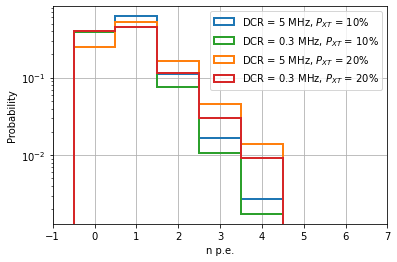

In [26]:
plt.hist(max_a, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'DCR = 5 MHz, $P_{XT}$ = 10%')
plt.hist(max_b, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'DCR = 0.3 MHz, $P_{XT}$ = 10%')
plt.hist(max_c, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'DCR = 5 MHz, $P_{XT}$ = 20%')
plt.hist(max_d, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:red', linewidth=2, density=True, label = 'DCR = 0.3 MHz, $P_{XT}$ = 20%')

plt.grid()
plt.yscale('log')
plt.legend()
#plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

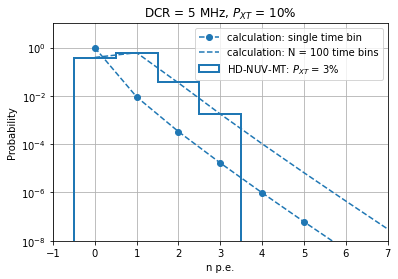

In [27]:
n_pe = 50
n_time_sampels = 100

plt.hist(np.max(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'HD-NUV-MT: $P_{XT}$ = 3%')

pdf_a = mpe_distribution_general_simple((NUV_HD_25um_03p_MT_data.nsb.rate_mhz*1.e6+NUV_HD_25um_03p_MT_data.sipm.dcr)*1.e-9,
                                        NUV_HD_25um_03p_MT_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_a, 'o--', color = 'tab:blue', label = 'calculation: single time bin')

pdf_a_sampels = get_trigger_probability(n_time_sampels, pdf_a.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_a_sampels, '--', color = 'tab:blue', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.grid()
plt.title('DCR = 5 MHz, $P_{XT}$ = 10%')
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

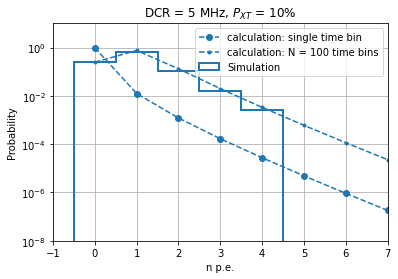

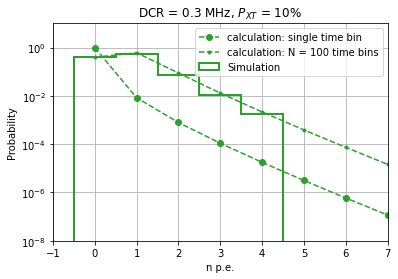

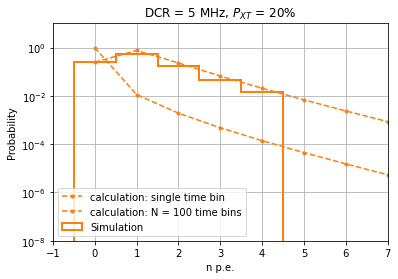

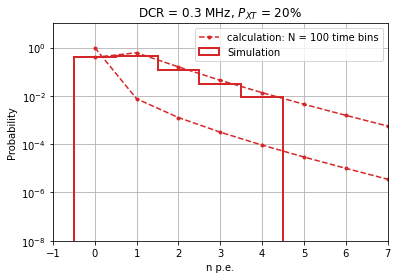

In [28]:
n_pe = 50
n_time_sampels = 100

plt.hist(max_a, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'Simulation')

pdf_a = mpe_distribution_general_simple((9e6+5e6)*1.e-9, 0.1, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_a, 'o--', color = 'tab:blue', label = 'calculation: single time bin')

pdf_a_sampels = get_trigger_probability(n_time_sampels, pdf_a.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_a_sampels, '.--', color = 'tab:blue', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.grid()
plt.title('DCR = 5 MHz, $P_{XT}$ = 10%')
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(max_b, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'Simulation')

pdf_b = mpe_distribution_general_simple((9e6+0.3e6)*1.e-9, 0.1, n_peaks=50)
plt.plot(np.arange(0, 50, 1), pdf_b, 'o--', color = 'tab:green', label = 'calculation: single time bin')

pdf_b_sampels = get_trigger_probability(n_time_sampels, pdf_b.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_b_sampels, '.--', color = 'tab:green', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.title('DCR = 0.3 MHz, $P_{XT}$ = 10%')
plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(max_c, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'Simulation')
pdf_c = mpe_distribution_general_simple((9e6+5e6)*1.e-9, 0.2, n_peaks=50)
plt.plot(np.arange(0, 50, 1), pdf_c, '.--', color = 'tab:orange', label = 'calculation: single time bin')

pdf_c_sampels = get_trigger_probability(n_time_sampels, pdf_c.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_c_sampels, '.--', color = 'tab:orange', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.title('DCR = 5 MHz, $P_{XT}$ = 20%')

plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()


plt.hist(max_d, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:red', linewidth=2, density=True, label = 'Simulation')
pdf_d = mpe_distribution_general_simple((9e6+0.3e6)*1.e-9, 0.2, n_peaks=50)
plt.plot(np.arange(0, 50, 1), pdf_d, '.--', color = 'tab:red')

pdf_d_sampels = get_trigger_probability(n_time_sampels, pdf_d.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_d_sampels, '.--', color = 'tab:red', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.title('DCR = 0.3 MHz, $P_{XT}$ = 20%')
plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

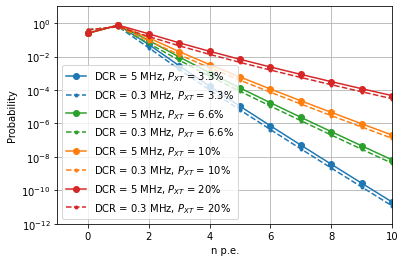

In [29]:
pdf_03a = mpe_distribution_general_simple((9e6+5e6)*1.e-9, 0.033, n_peaks=n_pe)
pdf_03a_sampels = get_trigger_probability(n_time_sampels, pdf_03a.reshape(n_pe))

pdf_03b = mpe_distribution_general_simple((9e6+0.3e6)*1.e-9, 0.033, n_peaks=n_pe)
pdf_03b_sampels = get_trigger_probability(n_time_sampels, pdf_03b.reshape(n_pe))

pdf_06a = mpe_distribution_general_simple((9e6+5e6)*1.e-9, 0.066, n_peaks=n_pe)
pdf_06a_sampels = get_trigger_probability(n_time_sampels, pdf_06a.reshape(n_pe))

pdf_06b = mpe_distribution_general_simple((9e6+0.3e6)*1.e-9, 0.066, n_peaks=n_pe)
pdf_06b_sampels = get_trigger_probability(n_time_sampels, pdf_06b.reshape(n_pe))


plt.plot(np.arange(0, 50, 1), pdf_03a_sampels, 'o-', color = 'tab:blue', 
         label = 'DCR = 5 MHz, $P_{XT}$ = 3.3%')
plt.plot(np.arange(0, 50, 1), pdf_03b_sampels, '.--', color = 'tab:blue', 
         label = 'DCR = 0.3 MHz, $P_{XT}$ = 3.3%')

plt.plot(np.arange(0, 50, 1), pdf_06a_sampels, 'o-', color = 'tab:green', 
         label = 'DCR = 5 MHz, $P_{XT}$ = 6.6%')
plt.plot(np.arange(0, 50, 1), pdf_06b_sampels, '.--', color = 'tab:green', 
         label = 'DCR = 0.3 MHz, $P_{XT}$ = 6.6%')


plt.plot(np.arange(0, 50, 1), pdf_a_sampels, 'o-', color = 'tab:orange', 
         label = 'DCR = 5 MHz, $P_{XT}$ = 10%')
plt.plot(np.arange(0, 50, 1), pdf_b_sampels, '.--', color = 'tab:orange', 
         label = 'DCR = 0.3 MHz, $P_{XT}$ = 10%')

plt.plot(np.arange(0, 50, 1), pdf_c_sampels, 'o-', color = 'tab:red', 
         label = 'DCR = 5 MHz, $P_{XT}$ = 20%')
plt.plot(np.arange(0, 50, 1), pdf_d_sampels, '.--', color = 'tab:red', 
         label = 'DCR = 0.3 MHz, $P_{XT}$ = 20%')


plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-12, 10)
plt.xlim(-1, 10)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

In [34]:
NUV_HD_25um_03p_MT_data.nsb.rate_mhz

9.003024259218773

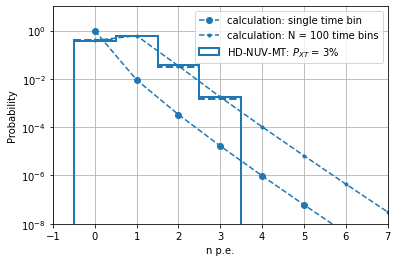

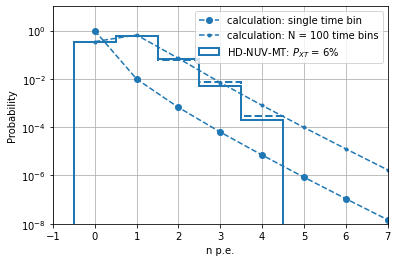

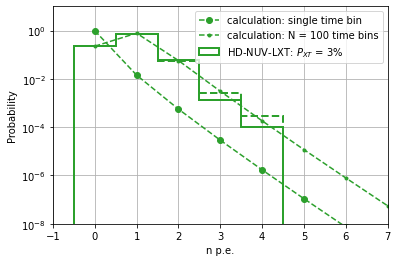

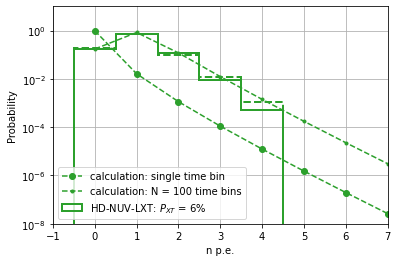

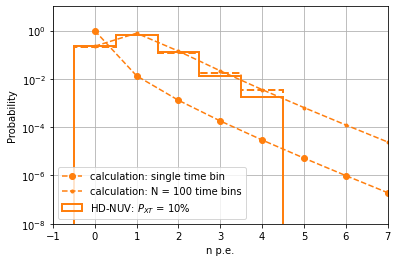

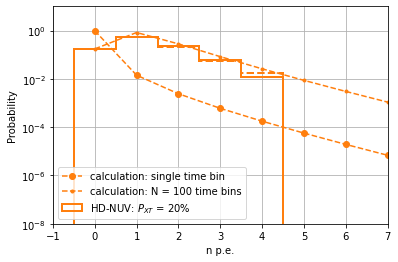

In [44]:
n_pe = 50
n_time_sampels = 100

plt.hist(np.max(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'HD-NUV-MT: $P_{XT}$ = 3%')
NUV_HD_25um_03p_MT_calc = calc_max_amplitude(NUV_HD_25um_03p_MT_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_03p_MT_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:blue', linewidth=2, density=True)

pdf_03p_MT = mpe_distribution_general_simple((NUV_HD_25um_03p_MT_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_03p_MT_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_03p_MT_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_03p_MT, 'o--', color = 'tab:blue', label = 'calculation: single time bin')

pdf_03p_MT_sampels = get_trigger_probability(n_time_sampels, pdf_03p_MT.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_03p_MT_sampels, '.--', color = 'tab:blue', label = 'calculation: N = {:} time bins'.format(n_time_sampels))


plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(np.max(NUV_HD_25um_06p_MT_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:blue', linewidth=2, density=True, label = 'HD-NUV-MT: $P_{XT}$ = 6%')
NUV_HD_25um_06p_MT_calc = calc_max_amplitude(NUV_HD_25um_06p_MT_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_06p_MT_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:blue', linewidth=2, density=True)

pdf_06p_MT = mpe_distribution_general_simple((NUV_HD_25um_06p_MT_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_06p_MT_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_06p_MT_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_06p_MT, 'o--', color = 'tab:blue', label = 'calculation: single time bin')

pdf_06p_MT_sampels = get_trigger_probability(n_time_sampels, pdf_06p_MT.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_06p_MT_sampels, '.--', color = 'tab:blue', label = 'calculation: N = {:} time bins'.format(n_time_sampels))



plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()


plt.hist(np.max(NUV_HD_25um_03p_LXT_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'HD-NUV-LXT: $P_{XT}$ = 3%')
NUV_HD_25um_03p_LXT_calc = calc_max_amplitude(NUV_HD_25um_03p_LXT_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_03p_LXT_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:green', linewidth=2, density=True)


pdf_03p_LXT = mpe_distribution_general_simple((NUV_HD_25um_03p_LXT_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_03p_LXT_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_03p_LXT_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_03p_LXT, 'o--', color = 'tab:green', label = 'calculation: single time bin')

pdf_03p_LXT_sampels = get_trigger_probability(n_time_sampels, pdf_03p_LXT.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_03p_LXT_sampels, '.--', color = 'tab:green', label = 'calculation: N = {:} time bins'.format(n_time_sampels))


plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(np.max(NUV_HD_25um_06p_LXT_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:green', linewidth=2, density=True, label = 'HD-NUV-LXT: $P_{XT}$ = 6%')
NUV_HD_25um_06p_LXT_calc = calc_max_amplitude(NUV_HD_25um_06p_LXT_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_06p_LXT_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:green', linewidth=2, density=True)

pdf_06p_LXT = mpe_distribution_general_simple((NUV_HD_25um_06p_LXT_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_06p_LXT_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_06p_LXT_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_06p_LXT, 'o--', color = 'tab:green', label = 'calculation: single time bin')

pdf_06p_LXT_sampels = get_trigger_probability(n_time_sampels, pdf_06p_LXT.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_06p_LXT_sampels, '.--', color = 'tab:green', label = 'calculation: N = {:} time bins'.format(n_time_sampels))

plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(np.max(NUV_HD_25um_10p_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'HD-NUV: $P_{XT}$ = 10%')
NUV_HD_25um_10p_calc = calc_max_amplitude(NUV_HD_25um_10p_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_10p_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:orange', linewidth=2, density=True)

pdf_10p = mpe_distribution_general_simple((NUV_HD_25um_10p_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_10p_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_10p_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_10p, 'o--', color = 'tab:orange', label = 'calculation: single time bin')

pdf_10p_sampels = get_trigger_probability(n_time_sampels, pdf_10p.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_10p_sampels, '.--', color = 'tab:orange', label = 'calculation: N = {:} time bins'.format(n_time_sampels))


plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.legend()
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

plt.hist(np.max(NUV_HD_25um_20p_data.amplitude_pe_detected[:,400:500], axis = 1), bins = 5, range = [-0.5, 4.5],
        histtype=u'step', color = 'tab:orange', linewidth=2, density=True, label = 'HD-NUV: $P_{XT}$ = 20%')
NUV_HD_25um_20p_calc = calc_max_amplitude(NUV_HD_25um_20p_pdf.reshape(50), np.arange(0, max_pe, 1))
plt.hist(NUV_HD_25um_20p_calc, bins = 5, range = [-0.5, 4.5],
        histtype=u'step', linestyle=('dashed'), color = 'tab:orange', linewidth=2, density=True)

pdf_20p = mpe_distribution_general_simple((NUV_HD_25um_20p_data.nsb.rate_mhz*1.e6
                                              +NUV_HD_25um_20p_data.sipm.dcr)*1.e-9, 
                                             NUV_HD_25um_20p_data.sipm.pxt, n_peaks=n_pe)
plt.plot(np.arange(0, 50, 1), pdf_20p, 'o--', color = 'tab:orange', label = 'calculation: single time bin')

pdf_20p_sampels = get_trigger_probability(n_time_sampels, pdf_20p.reshape(n_pe))
plt.plot(np.arange(0, 50, 1), pdf_20p_sampels, '.--', color = 'tab:orange', label = 'calculation: N = {:} time bins'.format(n_time_sampels))



plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-8, 10)
plt.xlim(-1, 7)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

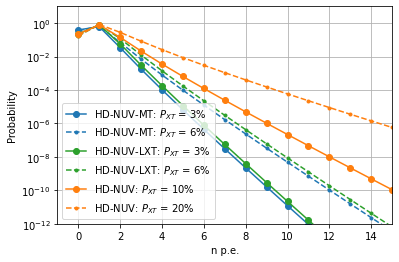

In [56]:

plt.plot(np.arange(0, 50, 1), pdf_03p_MT_sampels, 'o-', color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, 50, 1), pdf_06p_MT_sampels, '.--', color = 'tab:blue', label = 'HD-NUV-MT: $P_{XT}$ = 6%')


plt.plot(np.arange(0, 50, 1), pdf_03p_LXT_sampels, 'o-', color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 3%')
plt.plot(np.arange(0, 50, 1), pdf_06p_LXT_sampels, '.--', color = 'tab:green', label = 'HD-NUV-LXT: $P_{XT}$ = 6%')

plt.plot(np.arange(0, 50, 1), pdf_10p_sampels, 'o-', color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 10%')
plt.plot(np.arange(0, 50, 1), pdf_20p_sampels, '.--', color = 'tab:orange', label = 'HD-NUV: $P_{XT}$ = 20%')



plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim(1e-12, 10)
plt.xlim(-1, 15)
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.show()

(1e-05, 1)

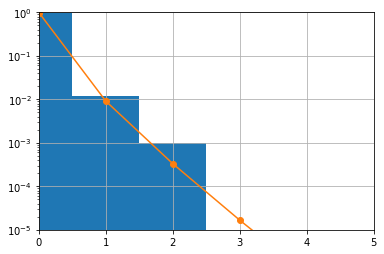

In [31]:
max_pe = 50
mu = (NUV_HD_25um_03p_MT_data.sipm.dcr + NUV_HD_25um_03p_MT_data.nsb.rate_mhz*1.e6)*1e-9
mu_xt = NUV_HD_25um_03p_MT_data.sipm.pxt

pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=max_pe)

plt.hist(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[0], bins = 5, range = [-0.5, 4.5], density=True)
plt.plot(np.arange(0, max_pe, 1), pdf, 'o-')
plt.grid()
plt.yscale('log')
plt.xlim(0, 5)
plt.ylim(1e-5, 1)

(1e-05, 1)

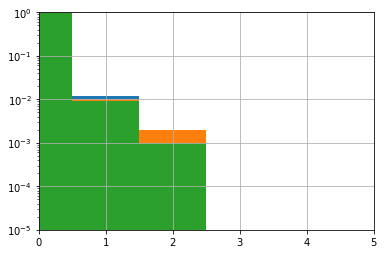

In [32]:
plt.hist(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[0], bins = 5, range = [-0.5, 4.5], density=True)
plt.hist(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[1], bins = 5, range = [-0.5, 4.5], density=True)
plt.hist(NUV_HD_25um_03p_MT_data.amplitude_pe_detected[3], bins = 5, range = [-0.5, 4.5], density=True)
plt.grid()
plt.yscale('log')
plt.xlim(0, 5)
plt.ylim(1e-5, 1)

In [33]:
NUV_HD_25um_03p_MT_data.amplitude_pe_detected.shape

(10000, 1000)

In [34]:
NUV_HD_25um_03p_MT_data.amplitude_pe_detected[:,:10].shape

(10000, 10)

In [35]:
a = NUV_HD_25um_03p_MT_data.amplitude_pe_detected[:,:800]
a = a.reshape(800*10000)

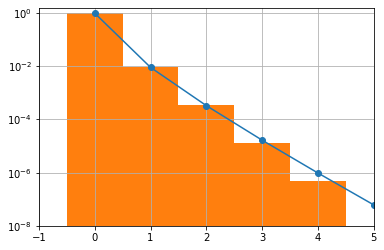

In [36]:
mu = (NUV_HD_25um_03p_MT_data.sipm.dcr + NUV_HD_25um_03p_MT_data.nsb.rate_mhz*1.e6)*1e-9
mu_xt = NUV_HD_25um_03p_MT_data.sipm.pxt

pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=max_pe)

a = NUV_HD_25um_03p_MT_data.amplitude_pe_detected[:,:800]
a = a.reshape(800*10000)

plt.plot(np.arange(0, max_pe, 1), pdf, 'o-')
plt.hist(a, bins = 5, range = [-0.5, 4.5], density=True)
plt.yscale('log')
plt.xlim(-1, 5)
plt.ylim(1e-8, 1.5)
plt.grid()

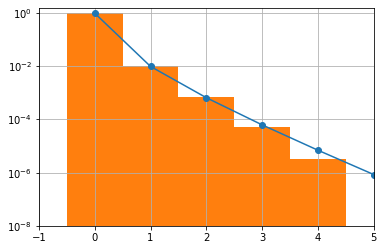

In [37]:
mu = (NUV_HD_25um_06p_MT_data.sipm.dcr + NUV_HD_25um_06p_MT_data.nsb.rate_mhz*1.e6)*1e-9
mu_xt = NUV_HD_25um_06p_MT_data.sipm.pxt

pdf = mpe_distribution_general_simple(mu, mu_xt, n_peaks=max_pe)

a = NUV_HD_25um_06p_MT_data.amplitude_pe_detected[:,:800]
a = a.reshape(800*10000)
plt.plot(np.arange(0, max_pe, 1), pdf, 'o-')
plt.hist(a, bins = 5, range = [-0.5, 4.5], density=True)
plt.yscale('log')
plt.xlim(-1, 5)
plt.ylim(1e-8, 1.5)
plt.grid()

In [38]:
NUV_HD_25um_20p_data

In [39]:
mu_xt

0.066

(1e-05, 1)

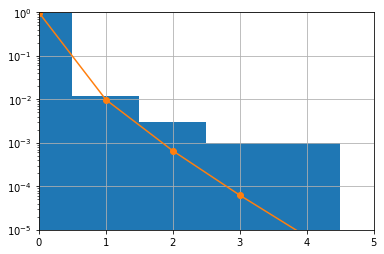

In [40]:
plt.hist(np.sum(NUV_HD_25um_03p_MT_data.amplitude_pe_detected, axis = 0)/1000, bins = 5, range = [-0.5, 4.5], density=True)
plt.plot(np.arange(0, max_pe, 1), pdf, 'o-')
plt.grid()
plt.yscale('log')
plt.xlim(0, 5)
plt.ylim(1e-5, 1)

In [ ]:
plt.hist( NUV_HD_25um_03p_MT_data.amplitude_pe_detected )

In [ ]:
l_window = 1e-9
nsb = 9e6
dcr = 5e6
n_pe = (nsb + dcr)*l_window
n_pe

In [ ]:
n_pe = (nsb + dcr)*l_window
n_pe

In [ ]:
n_pe = (nsb + 0.3e6)*l_window
n_pe

In [ ]:
photoelectron_peak = np.arange(50, dtype=np.int)
pdf = generalized_poisson(photoelectron_peak, [0.93/100, 1.4/100, 0.93/100, 1.4/100], [0.1, 0.1, 0.2, 0.2])

plt.plot(photoelectron_peak, 100*pdf[:,0], '.-', label = 'DCR = 0.3 MHz, Pxt = 10%')
plt.plot(photoelectron_peak, 100*pdf[:,1], '.-', label = 'DCR = 5 MHz, Pxt = 10%')
plt.plot(photoelectron_peak, 100*pdf[:,2], '.-', label = 'DCR = 0.3 MHz, Pxt = 20%')
plt.plot(photoelectron_peak, 100*pdf[:,3], '.-', label = 'DCR = 5 MHz, Pxt = 20%')
plt.grid()
plt.legend()
plt.xlim(-1, 15)
plt.ylim(1e-9, 100)
plt.yscale('log')
plt.show()
'''
n_pixels = 640

plt.plot(photoelectron_peak, n_pixels*pdf[:,0]/(100.e-9), '.-', label = 'DCR = 0.3 MHz, Pxt = 10%')
plt.plot(photoelectron_peak - 1, n_pixels*pdf[:,1]/(100.e-9), '.-', label = 'DCR = 5 MHz, Pxt = 10%')
plt.plot(photoelectron_peak, n_pixels*pdf[:,2]/(100.e-9), '.-', label = 'DCR = 0.3 MHz, Pxt = 20%')
plt.plot(photoelectron_peak - 1, n_pixels*pdf[:,3]/(100.e-9), '.-', label = 'DCR = 5 MHz, Pxt = 20%')
plt.grid()
plt.legend()
plt.xlim(-1, 15)
plt.ylim(10, 1e9)
plt.yscale('log')
'''

In [ ]:
def get_probability(threshold, data):

    probability = np.zeros(len(data))
    n_factor = np.sum(data)
    
    for index in range(len(threshold)):
        probability[index] = np.sum(data[index:])/n_factor
        
    return threshold, probability

In [ ]:
pdf[7,0]

In [ ]:
probability[7]

In [ ]:
threshold, probability = get_probability(photoelectron_peak, pdf[:,0])

In [ ]:
n_pixels

In [ ]:
plt.plot(threshold - 0.93, n_pixels*probability/l_window, label = 'DCR = 0.3 MHz, Pxt = 10%')
plt.xlim(-1, 15)
plt.ylim(10, 1e9)
plt.yscale('log')
plt.legend()
plt.grid()

In [ ]:
photoelectron_peak

In [ ]:
plt.plot(threshold, probability, '-')

In [ ]:
photoelectron_peak[0]

In [ ]:
pdf = generalized_poisson(photoelectron_peak, [1], [0.1])

In [ ]:
pdf

In [ ]:
mu = [1, 1]
mu_xt = [0.1, 0.2]
k = np.arange(5, dtype=np.int)
#mu + k * mu_xt

In [ ]:
k = k[:, np.newaxis]
k*mu_xt

In [ ]:
mu = 1
k = np.arange(3, dtype=np.int)
mu_xt = [0.1, 0.2]
#mu + k * mu_xt

In [ ]:
k = k[:, np.newaxis]

In [ ]:
k

In [ ]:
mu_xt = np.atleast_1d(mu_xt)
a = mu + k * mu_xt

In [ ]:
t = np.ones(3)
t = t[:, np.newaxis]
t

In [ ]:
a - t

In [ ]:
plt.plot(np.arange(0, len(pdf), 1), pdf, 'or')
plt.plot(x, pdf_gaus, '-')
plt.plot(x, np.sum(pdf*pdf_gaus, axis=-1), 'r-')
plt.xlim(-3, 10)
plt.grid()

In [ ]:
plt.plot(x, np.sum(pdf*pdf_gaus, axis=-1), '.-')
plt.xlim(-10, 100)
plt.grid()

In [ ]:
len(pdf_gaus[0])

In [ ]:
x = np.linspace(-1000, 1000, num=10000)
x

In [ ]:
x = np.atleast_1d(x)
x

In [ ]:
len(x)

In [ ]:
1 + 10 ** 2 / 12

In [ ]:
n_pe_5mhz = (nsb + 5e6)*l_window
n_pe_300khz = (nsb + 0.3e6)*l_window

n_pe_5mhz = n_pe_5mhz*(1 + pxt_10/(1-pxt_10))
n_pe_300khz = n_pe_300khz*(1 + pxt_10/(1-pxt_10))

#n_pe_p10 = n_pe*(1 + pxt_10/(1-pxt_10))
#n_pe_p20 = n_pe*(1 + pxt_20/(1-pxt_20))

In [ ]:
mu = n_pe
n_events = 100000000
sigma_5mhz = np.sqrt(n_pe_5mhz)
sigma_300khz = np.sqrt(n_pe_300khz)
#data_dc = np.random.normal(mu, sigma, n_events)
data_ac_5mhz = np.random.normal(0, sigma_5mhz, n_events)
data_ac_300khz = np.random.normal(0, sigma_300khz, n_events)

In [ ]:
plt.hist(data_ac_5mhz, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = '$DCR = 5 MHz')
plt.hist(data_ac_300khz, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = 'DCR = 300 kHZ')
plt.grid()
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.legend()

In [ ]:
rate_5mhz, thr = get_rate(data_ac_5mhz)
rate_300khz, thr = get_rate(data_ac_300khz)

In [ ]:
plt.plot(thr, rate_5mhz, label = 'DCR = 5 MHz')
plt.plot(thr, rate_300khz, label = 'DCR = 300 KHz')
plt.yscale('log')
plt.ylabel('Fake Trigger rate, Hz', fontsize=14)
plt.xlabel('threshold, p.e.', fontsize=14)
#plt.title('NSB = {:} MHz, DCR = {:} MHz, PXT = {:} %'.format(nsb/1e6, dcr/1e6, 100*pxt))
plt.ylim(1.0, 10e10)
plt.xlim(0.0, 10)
plt.grid()
plt.legend()
plt.savefig('trigger_rate_DCR.png', dpi = 200)

In [ ]:
plt.hist(data_ac_p10, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = '$P_{XT}$ = 10 %')
plt.hist(data_ac_p20, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = '$P_{XT}$ = 20 %')
plt.grid()
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.legend()

In [ ]:
def get_rate(data):
    
    thresholds = np.arange(0.1, 10., 0.1)
    n_pixels = 640
    read_out_window_100ns = 100e-9
    dead_time = 0e-9
    n_data = []
    
    for i_th in thresholds:
        n_data.append( len(data[data>i_th]) )
        
    n_data_rate = (n_pixels)*np.array(n_data)/(len(data)*(read_out_window_100ns+dead_time))
    
    return n_data_rate, thresholds

In [ ]:
rate_10p, thr = get_rate(data_ac_p10)
rate_20p, thr = get_rate(data_ac_p20)

In [ ]:
plt.plot(thr, rate_10p, label = '$P_{XT}$ = 10 %')
plt.plot(thr, rate_20p, label = '$P_{XT}$ = 20 %')
plt.yscale('log')
plt.ylabel('Fake Trigger rate, Hz', fontsize=14)
plt.xlabel('threshold, p.e.', fontsize=14)
plt.title('NSB = {:} MHz, DCR = {:} MHz, PXT = {:} %'.format(nsb/1e6, dcr/1e6, 100*pxt))
plt.ylim(1.0, 10e10)
plt.xlim(0.0, 10)
plt.grid()
plt.legend()
plt.savefig('trigger_rate_DCR.png', dpi = 200)

In [ ]:
plt.plot(thr, rate_10p, label = '$P_{XT}$ = 10 %')
plt.plot(thr, rate_20p, label = '$P_{XT}$ = 20 %')
plt.yscale('log')
plt.ylabel('Fake Trigger rate, Hz', fontsize=14)
plt.xlabel('threshold, p.e.', fontsize=14)
plt.title('NSB = {:} MHz, DCR = {:} MHz, PXT = {:} %'.format(nsb/1e6, dcr/1e6, 100*pxt))
plt.ylim(1.0, 10e10)
plt.xlim(0.0, 10)
plt.grid()
plt.legend()
plt.savefig('trigger_rate_DCR.png', dpi = 200)

In [ ]:
plt.hist(data_ac, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = '$\mu$ = 0')
plt.hist(data_dc, bins = 10, range = [-5, 7], histtype="step", linewidth=2, density=True, label = '$\mu$ = $n_{p.e.}$')
plt.grid()
plt.ylabel('Probability')
plt.xlabel('n p.e.')
plt.legend()
plt.savefig('dist.png', dpi = 200)

In [ ]:
thresholds = np.arange(0.1, 10., 0.1)
n_pixels = 640
read_out_window_100ns = 100e-9
dead_time = 0e-9
n_data_dc = []
n_data_ac = []

for i_th in thresholds:
    n_data_dc.append( len(data_dc[data_dc>i_th]) )
    n_data_ac.append( len(data_ac[data_ac>i_th]) )
    
n_data_ac_rate = (n_pixels)*np.array(n_data_ac)/(len(data_ac)*(read_out_window_100ns+dead_time))
n_data_dc_rate = (n_pixels)*np.array(n_data_dc)/(len(data_dc)*(read_out_window_100ns+dead_time))

In [ ]:
plt.plot(thresholds, n_data_ac_rate, label = '$\mu$ = 0')
plt.plot(thresholds, n_data_dc_rate, label = '$\mu$ = $n_{p.e.}$')
plt.yscale('log')
plt.ylabel('Fake Trigger rate, Hz', fontsize=14)
plt.xlabel('threshold, p.e.', fontsize=14)
plt.title('NSB = {:} MHz, DCR = {:} MHz, PXT = {:} %'.format(nsb/1e6, dcr/1e6, 100*pxt))
plt.ylim(1.0, 10e10)
plt.xlim(0.0, 10)
plt.grid()
plt.legend()
plt.savefig('trigger_rate.png', dpi = 200)

In [ ]:
nsb = np.array([5.94, 6.75, 7.56, 9.54, 5.94, 6.75, 7.56, 9.54])
dcr = np.array([9.003, 9.003, 9.982, 10.177, 9.003, 9.003, 9.982, 10.177])

In [ ]:
nsb + dcr

In [ ]:
size_mm = 3
size_mm*size_mm*70e3/1000000

In [ ]:
0.63 + 9.982